In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = False

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.01,
#                'log_scale': np.log(252 * 1.564e-5),
                'log_scale' : np.log(.1),
                'log_delta': np.log(0.6475),
               'rho': .5,
              }
else:
    #Daily
#      true_params ={'log_delta': -1.42,
#                    'rho':0.69,
#                    'log_scale': 1.85,
#                    'phi': -.3,
#                    'pi': -.07,
#                    'theta': .42}
    # Weekly
    true_params = {'log_delta': -0.2768983372209973,
                   'log_scale': 0.805773558068805,
                   'rho': 0.6097218157104826,
                   'phi': -0.8999999994952989,
                   # Here I use the daily value.
                   'pi': -.01,
                   'theta': 2.6348432313374923}
    
time_dim = 3700
sim_dim = 1000
innov_dim = 250

In [6]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], log_scale=true_params['log_scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [7]:
def compute_moments(log_delta, rho, log_scale, phi, pi, theta):
    
    vol_mean = np.exp(log_scale +  log_delta) / (1 - rho)
    vol_var = (2 * np.exp(log_scale) * rho * vol_mean + np.exp(log_scale)**2 * np.exp(log_delta)) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, log_scale=log_scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(log_delta=log_delta, rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [8]:
compute_moments(**true_params)

{'return_mean': -0.7325237240901902,
 'return_var': 0.9522173234111169,
 'vol_mean': 4.3482380711258575,
 'vol_var': 24.93917302392851}

In [9]:
vl.compute_gamma(**true_params)

-0.3497130692632163

In [10]:
total_true_params

{'log_delta': -0.2768983372209973,
 'log_scale': 0.805773558068805,
 'rho': 0.6097218157104826,
 'phi': -0.8999999994952989,
 'pi': -0.01,
 'theta': 2.6348432313374923,
 'gamma': -0.3497130692632163,
 'beta': -0.06829895205639659,
 'psi': -0.01973915638320306,
 'zeta': 0.19000000090846203}

In [11]:
true_params

{'log_delta': -0.2768983372209973,
 'log_scale': 0.805773558068805,
 'rho': 0.6097218157104826,
 'phi': -0.8999999994952989,
 'pi': -0.01,
 'theta': 2.6348432313374923}

In [12]:
total_true_params

{'log_delta': -0.2768983372209973,
 'log_scale': 0.805773558068805,
 'rho': 0.6097218157104826,
 'phi': -0.8999999994952989,
 'pi': -0.01,
 'theta': 2.6348432313374923,
 'gamma': -0.3497130692632163,
 'beta': -0.06829895205639659,
 'psi': -0.01973915638320306,
 'zeta': 0.19000000090846203}

## We start by examining the distributions of simulated data

In [13]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [14]:
data.corr()

,vol,rtn
vol,1.000000,-0.306303
rtn,-0.306303,1.000000


In [15]:
vl._vol_moments.jacobian([vl.log_delta, vl.log_scale, vl.rho])[2,0]

-2*(-_x*rho + _y - exp(log_delta + log_scale))*exp(log_delta + log_scale) - exp(log_delta + 2*log_scale)

In [16]:
vl.vol_moments_grad(data.vol,  omega['log_delta'], omega['log_scale'],omega['rho'])

NameError: name 'omega' is not defined

In [17]:
vl.vol_moments_grad(data.vol,  true_params['log_delta'], true_params['log_scale'], true_params['rho'])

,log_delta,log_scale,rho
0,-1.697022,-1.697022,-4.284071
1,-7.270165,-7.270165,-41.754559
2,-3.714435,-19.207052,-17.901709
3,-14.105865,-144.354352,-169.993347
4,-129.871089,-2051.111723,-3032.702425


In [18]:
data.head()

,vol,rtn
2000-01-01,0.431652,-0.170422
2000-01-02,2.490592,-0.539975
2000-01-03,3.425163,0.035989
2000-01-04,3.604213,-1.831948
2000-01-05,0.523565,-0.215298


In [19]:
data.vol.var()

23.403745379992188

In [20]:
init_constants = vl.compute_init_constants(data.vol)

In [21]:
init_constants

{'rho': 0.5869703097709816,
 'log_scale': 0.8134218482646135,
 'log_delta': -0.24262563387969427}

In [22]:
vl.compute_vol_gmm(data.vol, init_constants)

({'log_delta': -0.23798044478523453,
  'log_scale': 0.8005353616991159,
  'rho': 0.592012945255117},
            log_delta  log_scale       rho
 log_delta   0.002004  -0.000293 -0.000721
 log_scale  -0.000293   0.001203 -0.000245
 rho        -0.000721  -0.000245  0.000578)

In [23]:
omega, omega_cov = vl.estimate_params(data)

In [24]:
omega

{'gamma': -0.34992071578064454,
 'beta': -0.0687859135793083,
 'psi': -0.01637499741297264,
 'zeta': 0.1918232219358588,
 'log_delta': -0.23798044478523453,
 'log_scale': 0.8005353616991159,
 'rho': 0.592012945255117}

In [25]:
omega_cov

,beta,gamma,log_delta,log_scale,psi,rho,zeta
beta,4.421431e-07,-5.982118e-07,0.000000,0.000000,-3.024908e-07,0.000000,0.000000
gamma,-5.982118e-07,3.539824e-06,0.000000,0.000000,-2.280518e-07,0.000000,0.000000
log_delta,0.000000e+00,0.000000e+00,0.002004,-0.000293,0.000000e+00,-0.000721,0.000000
log_scale,0.000000e+00,0.000000e+00,-0.000293,0.001203,0.000000e+00,-0.000245,0.000000
psi,-3.024908e-07,-2.280518e-07,0.000000,0.000000,1.246976e-05,0.000000,0.000000
rho,0.000000e+00,0.000000e+00,-0.000721,-0.000245,0.000000e+00,0.000578,0.000000
zeta,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000019


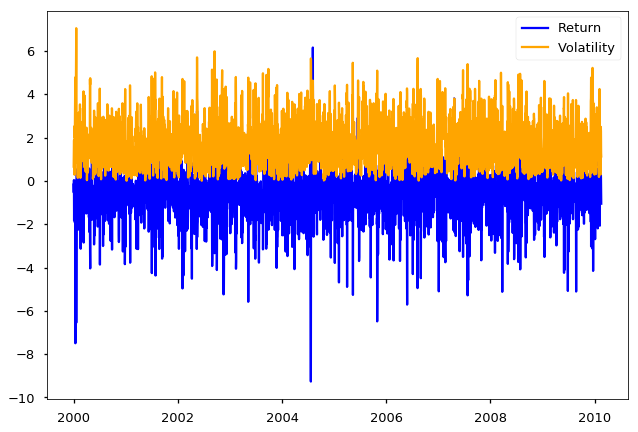

In [26]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [27]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,1.111210,-0.303722
rtn,-0.303722,1.015717


In [28]:
total_true_params

{'log_delta': -0.2768983372209973,
 'log_scale': 0.805773558068805,
 'rho': 0.6097218157104826,
 'phi': -0.8999999994952989,
 'pi': -0.01,
 'theta': 2.6348432313374923,
 'gamma': -0.3497130692632163,
 'beta': -0.06829895205639659,
 'psi': -0.01973915638320306,
 'zeta': 0.19000000090846203}

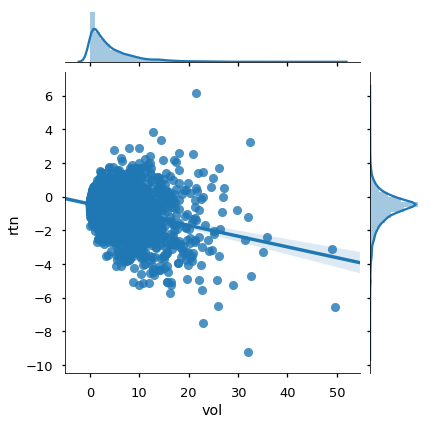

In [29]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [30]:
data.describe()

,vol,rtn
count,3700.000000,3700.000000
mean,4.283257,-0.714613
std,4.837742,1.007828
min,0.000039,-9.263589
25%,0.945520,-1.111556
50%,2.663745,-0.572350
75%,5.926891,-0.186246
max,49.681826,6.155242


## I now estimate all of the parameters

In [31]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [32]:
def vol_estimator(data):
    return vl.compute_vol_gmm(data.vol, init_constants=vl.compute_init_constants(data.vol))

In [33]:
vol_estimator(data_arr[2])

({'log_delta': -0.29929302175500494,
  'log_scale': 0.792254561612991,
  'rho': 0.5996715016739024},
            log_delta  log_scale       rho
 log_delta   0.002104  -0.000584 -0.000630
 log_scale  -0.000584   0.001486 -0.000191
 rho        -0.000630  -0.000191  0.000500)

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vol_estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
vol_params = pd.Series(true_params).loc[['log_delta', 'log_scale', 'rho']]

In [ ]:
ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
            for est in est_arr]

In [ ]:
vol_fig, vol_ax = mpl.pyplot.subplots()
sns.distplot(ar_stats, ax=vol_ax)
vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
vol_ax.set_xlim([0,20])
vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [ ]:
t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
            for est in est_arr for name in ['rho', 'log_scale', 'log_delta']]
t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [ ]:
vl.compute_init_constants(data.vol)

In [ ]:
true_params['log_delta']

In [ ]:
np.amax([est[0]['log_delta'] for est in est_arr])

In [ ]:
t_stats_df.describe()

In [ ]:

for name, col in t_stats_df.items():
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

In [ ]:
estimatoar = partial(vl.estimate_params_strong_id, case=1)

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_delta=true_params['log_delta'],
                                                   rho=true_params['rho'], log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
#         if max(ax.get_xlim()) > 20:
#             ax.set_xlim(-20, 20)

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        ax.axvline(total_true_params[name], color='black')
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega


In [ ]:
true_params

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [ ]:
def compute_ar(params, case=1):
    param_est, param_cov = params
    names = vl.compute_names(case)
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov, case=case)

In [ ]:
param_est, param_cov = est_arr[0]
names = vl.compute_names(1)
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
# data.shape[0] * vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
vl.compute_link(prices=true_prices, omega=omega, case=1)

In [ ]:
vl._link_grad_in1(*true_prices, **omega)

In [ ]:
compute_ar(est_arr[0])

In [ ]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
 stats.chi2.ppf(df=4, q=.95)

In [ ]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)